In [4]:
!pip install mnist

In [279]:
import warnings
warnings.filterwarnings('ignore')

In [306]:
import os
print(os.getcwd())
import pandas as pd
import seaborn as sns
import mnist
%matplotlib inline

/Users/maalej_ach/Desktop/ach/Achraf-projects/Projet_Conception_MAALEJ_BEJAOUI_RATINEY


In [337]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.csgraph
from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import confusion_matrix, classification_report

In [338]:
def load_shuffle_data(images):
    images = mnist.train_images()
    labels = mnist.train_labels()
    rng = np.random.RandomState(0)
    indices = np.arange(len(images))
    rng.shuffle(indices)

    X=[];
    y=[];
    for i in indices:
        X.append(images[i].flatten())
        y.append(labels[i])
    return X,y

In [339]:
X,y = load_shuffle_data(images)

In [340]:
len(y)

60000

In [341]:
def sample_unlabel_data(X,y,nb_total_samples,nb_labeled_points):
    X_sample = X[:nb_total_samples]
    y_sample = y[:nb_total_samples]
    indices = np.arange(nb_total_samples)
    unlabeled_set = indices[nb_labeled_points:]
    x_train=X_sample
    y_train = list(y_sample) 
    for i in unlabeled_set :
        y_train[i] = -1
    return x_train , y_train , X_sample , y_sample ,unlabeled_set

In [342]:
x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,1000,100)

In [343]:
def train_model(x_train,y_train,kernel = 'rbf',gamma = 0.0001,max_iter = 10,alpha = 0.2 , n_neighbors = 7):
    lp_model = label_propagation.LabelSpreading(kernel=kernel,gamma=gamma, n_neighbors = n_neighbors,max_iter=max_iter,alpha=alpha)
    lp_model.fit(x_train, y_train)
    return lp_model

In [344]:
def Find_best_gamma(x_train,y_train,y_sample):
    liste_gamma=[]
    liste_score=[]
    score_max=0;
    for i in range(140):
        liste_gamma.append(i/1000000)
        lp_model = train_model(x_train,y_train,kernel='rbf',gamma=i/1000000, max_iter=10,alpha=0.2)
        lp_model.fit(x_train, y_train)
        score=lp_model.score(x_train, y_sample)
        liste_score.append(score)
        if score>score_max:
            score_max=score
            gamma_max=i/1000000;
    
    return gamma_max , liste_gamma , liste_score

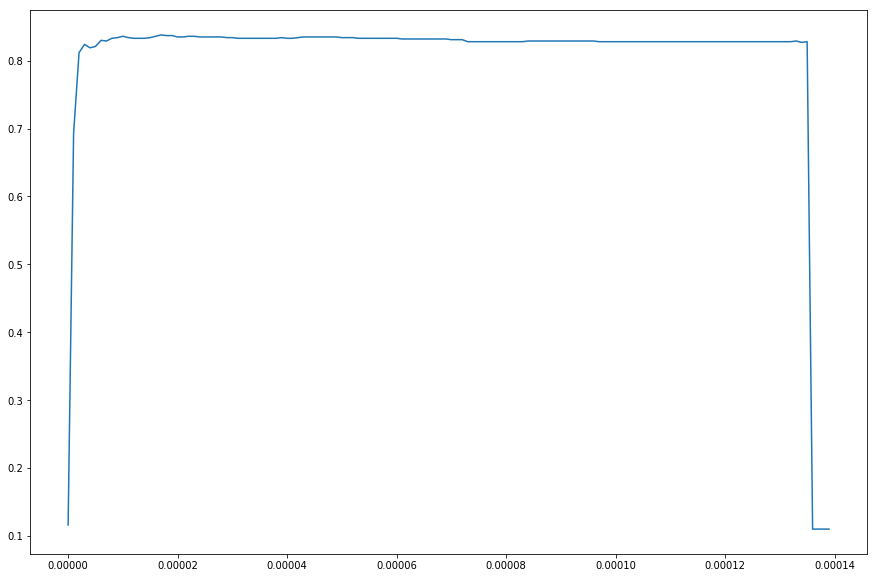

In [316]:
gamma_max ,liste_gamma , liste_score = Find_best_gamma(x_train,y_train,y_sample)
plt.figure(figsize=(15,10))
plt.plot(liste_gamma,liste_score)
plt.show()

In [317]:
lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
lp_model

LabelSpreading(alpha=0.2, gamma=1.7e-05, kernel='rbf', max_iter=10,
        n_jobs=None, n_neighbors=7, tol=0.001)

In [323]:
def classification_results(lp_model,x_train,y_sample,unlabeled_set):
    
    def plot_cm(cm,classes):
        df_cm = pd.DataFrame(cm, index = [c for c in classes],
                  columns = [c for c in classes])
        plt.figure(figsize = (12,8))
        sns.heatmap(df_cm,annot=True,cmap='Blues')
    
    nb_total_samples = len(x_train)
    nb_labeled_points = nb_total_samples - len(unlabeled_set)
    score = lp_model.score(x_train, y_sample)
    predicted_labels=lp_model.transduction_[unlabeled_set]
    true_labels = y_sample[nb_labeled_points:]
    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
     
    
    print("le modèle avec un noyau",lp_model.kernel) 
    print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
          (nb_labeled_points, nb_total_samples - nb_labeled_points, nb_total_samples))

    print(classification_report(true_labels, predicted_labels))
    print("score : ",score)
    print("Confusion matrix : ")
    plot_cm(cm,lp_model.classes_)

le modèle avec un noyau rbf
Label Spreading model: 100 labeled & 900 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        98
           1       0.89      0.99      0.94       103
           2       0.91      0.84      0.87        85
           3       0.81      0.83      0.82        94
           4       0.69      0.82      0.75        85
           5       0.86      0.56      0.68        77
           6       0.97      0.92      0.94       100
           7       0.83      0.84      0.84       103
           8       0.59      0.74      0.66        77
           9       0.67      0.63      0.65        78

   micro avg       0.82      0.82      0.82       900
   macro avg       0.82      0.81      0.81       900
weighted avg       0.83      0.82      0.82       900

score :  0.838
Confusion matrix : 


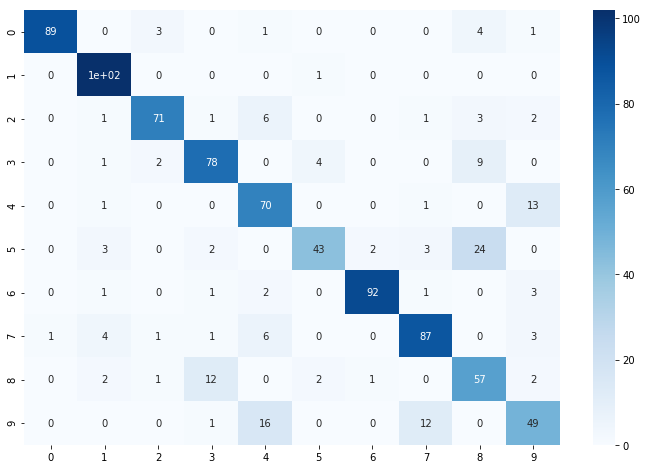

In [324]:
classification_results(lp_model,x_train,y_sample,unlabeled_set)

In [325]:
def Find_best_NbNeighbors(x_train,y_train,y_sample):
    liste_neighbors=[]
    liste_score=[]
    score_max=0;
    for i in range(1,30):
        liste_neighbors.append(i)
        lp_model = train_model(x_train,y_train,kernel='knn',n_neighbors = i, max_iter=10,alpha=0.2)
        lp_model.fit(x_train, y_train)
        score=lp_model.score(x_train, y_sample)
        liste_score.append(score)
        if score>score_max:
            score_max=score
            n_neighbors_max=i;
    
    return n_neighbors_max , liste_neighbors , liste_score

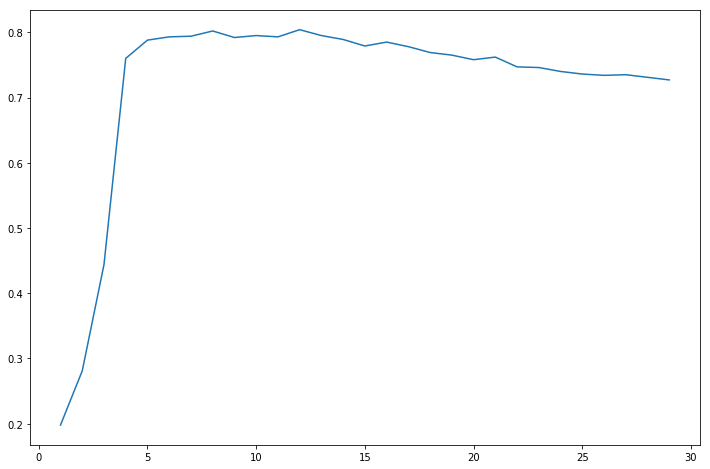

In [326]:
n_neighbors_max , liste_neighbors , liste_score = Find_best_NbNeighbors(x_train,y_train,y_sample)
plt.figure(figsize=(12,8))
plt.plot(liste_neighbors,liste_score)
plt.show()

In [251]:
lp_model = train_model(x_train,y_train,kernel = 'knn',n_neighbors = n_neighbors_max,max_iter = 10,alpha = 0.2)
lp_model

LabelSpreading(alpha=0.2, gamma=0.0001, kernel='knn', max_iter=10,
        n_jobs=None, n_neighbors=12, tol=0.001)

le modèle avec un noyau knn
Label Spreading model: 100 labeled & 900 unlabeled points (1000 total)
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        98
           1       0.70      1.00      0.82       103
           2       0.92      0.69      0.79        85
           3       0.68      0.81      0.74        94
           4       0.63      0.79      0.70        85
           5       0.88      0.48      0.62        77
           6       0.88      0.92      0.90       100
           7       0.80      0.83      0.82       103
           8       0.69      0.55      0.61        77
           9       0.71      0.58      0.64        78

   micro avg       0.78      0.78      0.78       900
   macro avg       0.79      0.76      0.76       900
weighted avg       0.79      0.78      0.77       900

score :  0.804
Confusion matrix : 


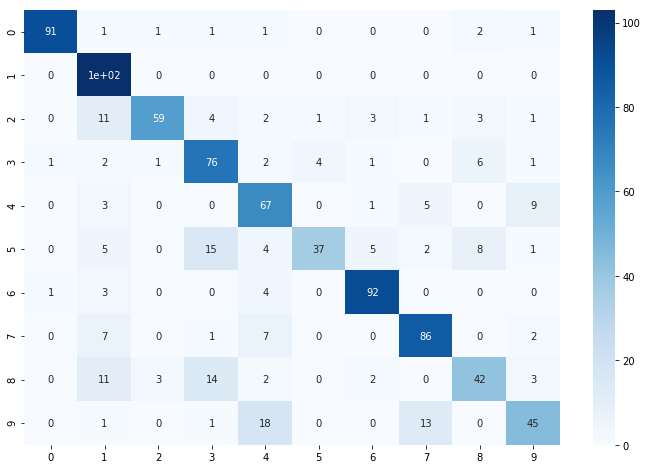

In [260]:
classification_results(lp_model,x_train,y,unlabeled_set)

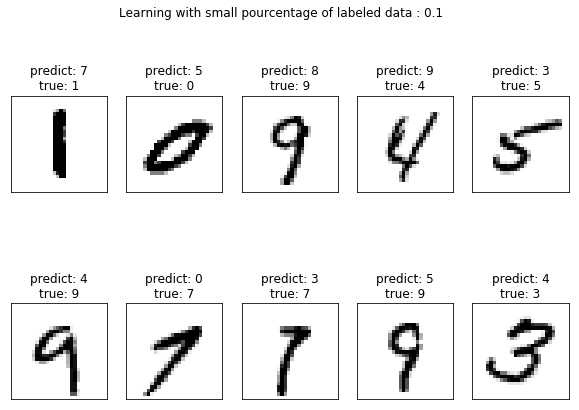

In [369]:
x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,1000,100)
lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(2,figsize=(10, 7))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index].flatten()
    im=np.zeros((28,28))
    for i in range(len(image)):
        im[int(i/28),i%28]=image[i]
    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(im, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
    lp_model.transduction_[image_index], labels[image_index]))

f.suptitle('Learning with small pourcentage of labeled data : '+str(0.1))
plt.show()

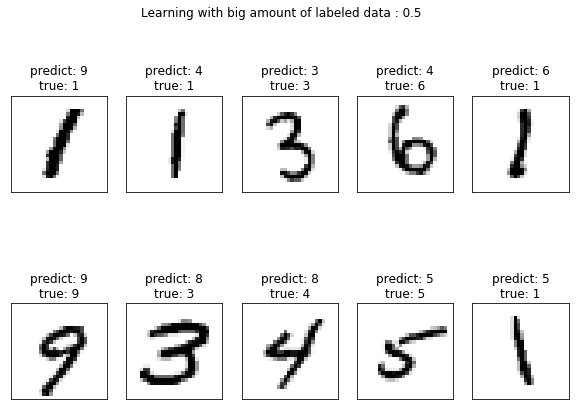

In [370]:
x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,200,100)
lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(2,figsize=(10, 7))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index].flatten()
    im=np.zeros((28,28))
    for i in range(len(image)):
        im[int(i/28),i%28]=image[i]
    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(im, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
    lp_model.transduction_[image_index], labels[image_index]))

f.suptitle('Learning with big amount of labeled data : '+str(0.5) )
plt.show()

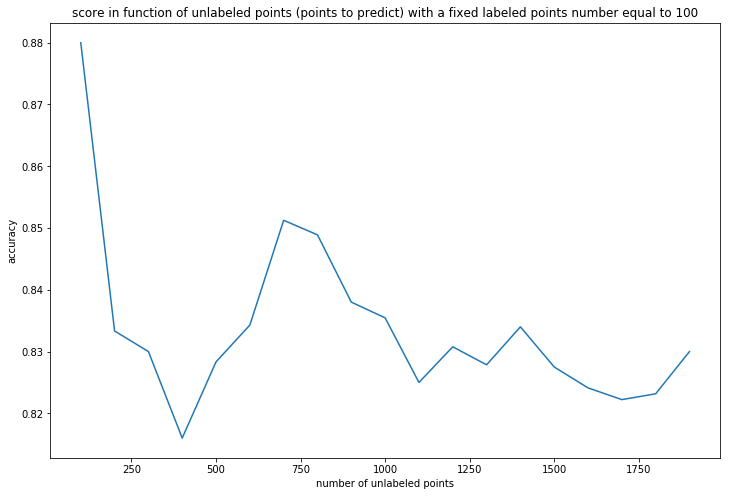

In [296]:
gamma_max = 1.7e-05
liste_x=[];
liste_score=[];
for i in range(1,20):
    x = i*100
    x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,x+100,100)
    lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
    lp_model.fit(x_train, y_train)
    score = lp_model.score(x_train, y_sample)
    liste_score.append(score);
    liste_x.append(x)

plt.figure(figsize=(12,8))
plt.plot(liste_x,liste_score)
plt.title("score in function of unlabeled points (points to predict) with a fixed labeled points number equal to 100")
plt.ylabel("accuracy")
plt.xlabel("number of unlabeled points")
plt.show()

0.16666666666666666
0.2857142857142857
0.375
0.4444444444444444
0.5
0.5454545454545454
0.5833333333333334
0.6153846153846154
0.6428571428571429
0.6666666666666666
0.6875
0.7058823529411765
0.7222222222222222
0.7368421052631579
0.75
0.7619047619047619
0.7727272727272727
0.782608695652174
0.7916666666666666


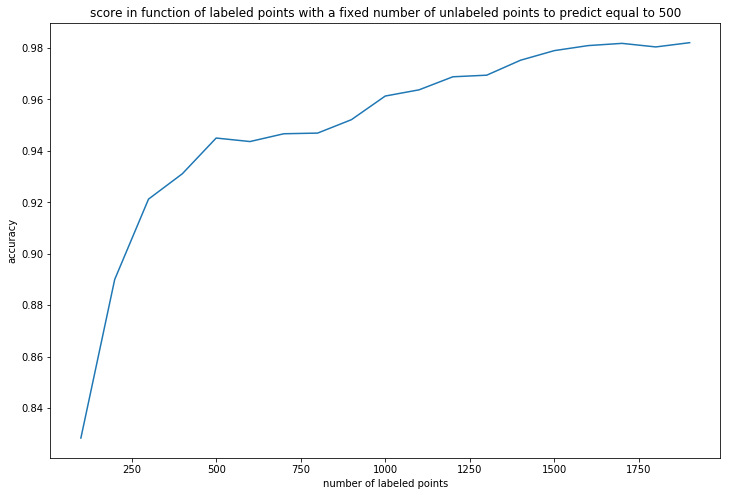

In [332]:
gamma_max = 1.7e-05
liste_x=[];
liste_score=[];
for i in range(1,20):
    x = i*100
    print(x/(x+500))
    x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,x+500,x)
    lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
    lp_model.fit(x_train, y_train)
    score = lp_model.score(x_train, y_sample)
    liste_score.append(score);
    liste_x.append(x)

plt.figure(figsize=(12,8))
plt.plot(liste_x,liste_score)
plt.title("score in function of labeled points with a fixed number of unlabeled points to predict equal to 500")
plt.ylabel("accuracy")
plt.xlabel("number of labeled points")
plt.show()

the more information we have with the labeled points the better our classification.
We tend to a supervised learning

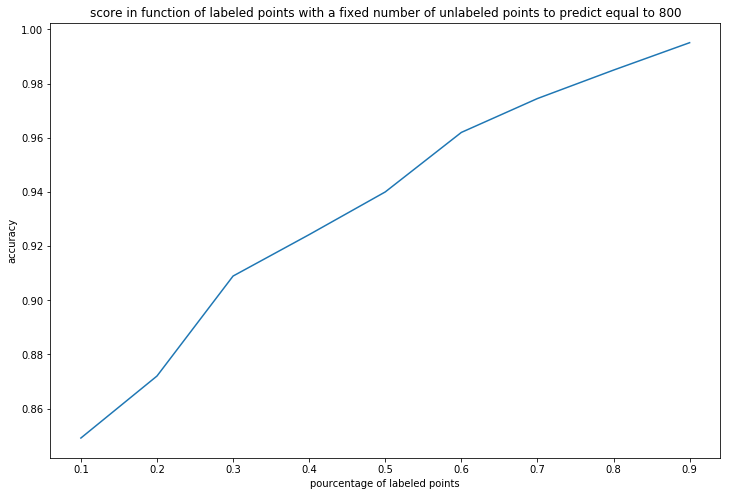

In [333]:
gamma_max = 1.7e-05
liste_p=[];
liste_score=[];
for i in range(1,10):
    p=i/10
    x=int((p/(1-p))*800)
    x_train , y_train , X_sample , y_sample , unlabeled_set = sample_unlabel_data(X,y,x+800,x)
    lp_model = train_model(x_train,y_train,kernel = 'rbf',gamma = gamma_max,max_iter = 10,alpha = 0.2)
    lp_model.fit(x_train, y_train)
    score = lp_model.score(x_train, y_sample)
    liste_score.append(score);
    liste_p.append(p)

plt.figure(figsize=(12,8))
plt.plot(liste_p,liste_score)
plt.title("score in function of labeled points with a fixed number of unlabeled points to predict equal to 800")
plt.ylabel("accuracy")
plt.xlabel("pourcentage of labeled points")
plt.show()